# 6장. 텍스트와 시퀀스를 위한 딥러닝
텍스트, 시계열, 시퀀스 데이터를 처리하는 딥러닝 모델  
- 순환 신경망
- 1D 컨브넷
> 2D 컨브넷의 1차원 버전

## 6.1 텍스트 데이터 다루기
텍스트는 가장 흔한 시퀀스 형태의 데이터  
단어 수준으로 작업을 많이 함  

다음과 같은 문제에서 진행
- 문서 분류
- 감성 분석
- 저자 식별
- 제한된 범위의 질문 응답

딥러닝 모델은 수치형 텐서만 다루기 때문에  
텍스트를 수치형 텐서로 변환  
**텍스트 벡터화**  
- 텍스트를 단어로 나누고 각 단어를 하나의 벡터로 변환
- 텍스트를 문자로 나누고 각 문자를 하나의 벡터로 변환
- 텍스트에서 단어나 문자의 **n-그램**을 추출하여 n-그램을 하나의 벡터로 변환
> n-그램, 연속된 단어나 문자의 그룹

텍스트를 이런 단위로 나눈 것을 **토큰**이라 하며,  
토큰으로 나누는 작업을 **토큰화**라고 한다.

텍스트의 토큰화는 그저 단어들을 규칙에 따라 나눴을 뿐  
이를 벡터화 해야 할 필요가 있음  
- 원-핫 인코딩
- 단어 임베딩




### 단어와 문자의 원-핫 인코딩

In [ ]:
# 단어 수준의 원-핫 인코딩하기(간단한 예)
import numpy as np

samples = ['The cat sat on the mat.', 'The dog ate my homework.']

token_index = {}
for sample in samples:
    for word in sample.split():
        if word not in token_index:
            token_index[word] = len(token_index) + 1

max_length = 10

results = np.zeros(shape = (len(samples),
                            max_length,
                            max(token_index.values()) + 1))

for i, sample in enumerate(samples):
    for j, word in list(enumerate(sample.split()))[:max_length]:
        index = token_index.get(word)
        results[i, j, index] = 1.

In [ ]:
# 문자 수준 원-핫 인코딩하기(간단한 예)
import string

samples = ['The cat sat on the mat.', 'The dog ate my homework.']
characters = string.printable
token_index = dict(zip(characters, range(1, len(characters) + 1)))

max_length = 50
results = np.zeros((len(samples), 
                    max_length,
                    max(token_index.values()) + 1))
for i, sample in enumerate(samples):
    for j, character in enumerate(sample):
        index = token_index.get(character)
        results[i, j, index] = 1.

In [ ]:
# 케라스를 사용한 단어 수준의 원-핫 인코딩하기
from keras.preprocessing.text import Tokenizer

samples = ['The cat sat on the mat.', 'The dog ate my homework.']

tokenizer = Tokenizer(num_words = 1000)
tokenizer.fit_on_texts(samples)

sequences = tokenizer.texts_to_sequences(samples)

one_hot_results = tokenizer.texts_to_matrix(samples, mode = 'binary')

word_index = tokenizer.word_index
print('%s개의 고유한 토큰을 찾았습니다.'%len(word_index))

9개의 고유한 토큰을 찾았습니다.


원-핫 인코딩의 변종 중 하나는 **원-핫 해싱** 기법  
이 방식은 어휘 사전에 있는 고유한 토큰의 수가 너무 커서 모두 다루기 힘들 때 사용   
각 단어에 명시적으로 인덱스를 할당하고,  
인덱스를 딕셔너리에 저장하는 대신에 단어를 해싱하여 고정된 크기의 벡터로 변환

장점
- 명시적 단어 인덱스가 필요 없어 메모리 절약 가능

단점
- 해시 충돌
> 2개의 단어가 같은 해시를 만들면 머신 러닝 모델은 단어 사이의 차이를 알지 못함


In [ ]:
# 해싱 기법을 사용한 단어 수준의 원-핫 인코딩하기(간단한 예)
samples = ['The cat sat on the mat.', 'The dog ate my homework.']

dimensionality = 1000
max_length = 10

results = np.zeros((len(samples),
                    max_length,
                    dimensionality))
for i, sample in enumerate(samples):
    for j, word in list(enumerate(sample))[:max_length]:
        index = abs(hash(word)) % dimensionality
        results[i, j, index] = 1.

### 단어 임베딩 사용하기
**단어와 벡터를 연관 짓는 방법**  

원-핫 인코딩의 경우 고차원이며, 대부분이 0으로 채워져 있고 수동으로 인코딩 함  
단어 임베딩의 경우 저차원의 실수형 벡터이며, 데이터로 부터 학습을 함  

단어 임베딩 방법
- 관심 대상인 문제와 함께 단어 임베딩을 학습
- 사전 훈련된 단어 임베딩



#### Embedding 층을 사용하여 단어 임베딩 학습하기

단어와 밀집 벡터를 랜덤으로 매핑 시키면  
비슷한 의미의 단어들이 서로 다른 임베딩을 갖게 됨  

하지만 각 관계를 잘 나타내는 임베딩은 찾기 힘듦  
문제의 목적과 분야에 따라서 단어 임베딩이 달라짐  
즉, 자신의 목적과 분야에 맞게 새롭게 임베딩을 시켜줘야 함  

역전파와 케라스를 활용해 Embedding 층의 가중치 학습으로 해결


In [ ]:
# Embedding 층의 객체 생성하기
from keras.layers import Embedding

embedding_layer = Embedding(1000, 64)

Embedding 층을 정수 인덱스를 밀집 벡터로 매핑하는 딕셔너리로 이해하는 것이 좋음  
Embedding 층은 (samples, sequence_length)인 2D 정수 텐서를 입력 받아  
(samples, sequence_length, embedding_dimensionality) 3D 실수형 텐서를 반환  



In [ ]:
# Embedding 층에 사용할 IMDB 데이터 로드하기
from keras.datasets import imdb
from keras import preprocessing

max_features = 10000
maxlen = 20

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words = max_features)

x_train = preprocessing.sequence.pad_sequences(x_train, maxlen = maxlen)
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen = maxlen)

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 

In [ ]:
# IMDB 데이터에 Embedding 층과 분류기 사용하기
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding

model = Sequential()
model.add(Embedding(10000, 8, input_length = maxlen))

model.add(Flatten())

model.add(Dense(1, activation = 'sigmoid'))
model.compile(optimizer = 'rmsprop',
              loss = 'binary_crossentropy',
              metrics = ['acc'])
model.summary()

history = model.fit(x_train,
                    y_train,
                    epochs = 10,
                    batch_size = 32,
                    validation_split = 0.2)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 20, 8)             80000     
_________________________________________________________________
flatten_1 (Flatten)          (None, 160)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 161       
Total params: 80,161
Trainable params: 80,161
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
625/625 [==============================] - 2s 2ms/step - loss: 0.6872 - acc: 0.5514 - val_loss: 0.6304 - val_acc: 0.6962
Epoch 2/10
625/625 [==============================] - 1s 2ms/step - loss: 0.5782 - acc: 0.7500 - val_loss: 0.5298 - val_acc: 0.7288
Epoch 3/10
625/625 [==============================] - 1s 1ms/step - loss: 0.4716 - acc: 0.7836 - val_loss: 0.5017 - 

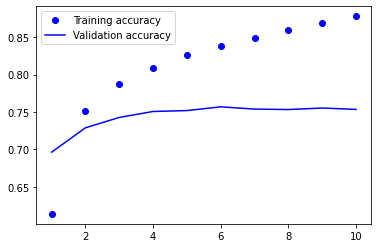

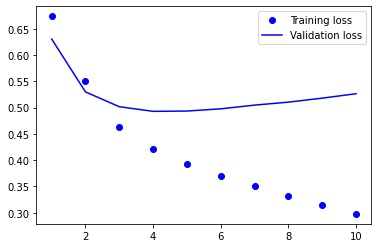

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label = 'Training accuracy')
plt.plot(epochs, val_acc, 'b', label = 'Validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.legend()

검증 정확도는 약 75%  
하지만, 이 경우 임베딩 시퀀스를 펼치고 하나의 Dense 층을 훈련  
입력 시퀀스에 있는 각 단어를 독립적으로 다룸

#### 사전 훈련된 단어 임베딩 사용하기
훈련 데이터가 부족해 작업에 맞는 단어 임베딩을 학습 할 수 없을 때 사용

사용할 알고리즘 [**GloVe**](http://mng.bz/0tIo)  
- 단어의 동시 출현 통계를 기록한 행렬을 분해하는 기법 사용




### 모든 내용을 적용하기: 원본 텍스트에서 단어 임베딩까지

#### 원본 IMDB 텍스트 내려받기


In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
%cd /content/gdrive/MyDrive/datasets/

/content/gdrive/MyDrive/datasets


In [ ]:
!unzip -q aclImdb.zip

In [ ]:
# IMDB 원본 데이터 전처리하기
import os

imdb_dir = './aclImdb'
train_dir = os.path.join(imdb_dir, 'train')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname), encoding = 'utf-8')
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

#### 데이터 토큰화


In [ ]:
# IMDB 원본 데이터의 텍스트를 토큰화하기
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen = 100
training_samples = 200
validation_samples = 10000
max_words = 10000

tokenizer = Tokenizer(num_words = max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('%s개의 고유한 토큰을 찾았습니다.'%len(word_index))

data = pad_sequences(sequences, maxlen = maxlen)
labels = np.asarray(labels)
print('데이터 텐서의 크기:', data.shape)
print('레이블 텐서의 크기:', labels.shape)

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples:training_samples + validation_samples]
y_val = labels[training_samples:training_samples + validation_samples]

88582개의 고유한 토큰을 찾았습니다.
데이터 텐서의 크기: (25000, 100)
레이블 텐서의 크기: (25000,)


#### GloVe 단어 임베딩 내려받기


In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2020-12-30 11:20:54--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-12-30 11:20:54--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-12-30 11:20:54--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [ ]:
!unzip -qq glove.6B.zip

##### 임베딩 전처리


In [ ]:
# GloVe 단어 임베딩 파일 파싱하기
embeddings_index = {}
f = open('glove.6B.100d.txt', encoding = 'utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype = 'float32')
    embeddings_index[word] = coefs
f.close()

print('%s개의 단어 벡터를 찾았습니다.'%len(embeddings_index))

400000개의 단어 벡터를 찾았습니다.


In [ ]:
# GloVe 단어 임베딩 행렬 준비하기
embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

이때, 인베딩 인덱스에 없는 단어는 모두 0이 됨

#### 모델 정의하기


In [ ]:
# 모델 정의하기
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length = maxlen))
model.add(Flatten())
model.add(Dense(32, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          1000000   
_________________________________________________________________
flatten (Flatten)            (None, 10000)             0         
_________________________________________________________________
dense (Dense)                (None, 32)                320032    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


#### 모델에 GloVe 임베딩 로드하기

Embedding 층은 하나의 가중치 행렬을 가짐  
이 행렬은 2D 부동 소수 행렬이며,  
각 i 번째 원소는 i 번째 인덱스에 상응하는 단어 벡터

In [ ]:
# 사전 훈련된 단어 임베딩을 Embedding 층에 로드하기
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

Embedding 층을 동결함
- 모델 일부는 사전 훈련되고 다른 부분은 랜덤하게 초기화 하기 위함


#### 모델 훈련과 평가

In [ ]:
# 훈련과 평가하기
model.compile(optimizer = 'rmsprop',
              loss = 'binary_crossentropy',
              metrics = ['acc'])
history = model.fit(x_train, y_train,
                    epochs = 10,
                    batch_size = 32,
                    validation_data = (x_val, y_val))
model.save_weights('pre_trained_glove_model.h5')

Epoch 1/10
7/7 [==============================] - 2s 161ms/step - loss: 1.1712 - acc: 0.5169 - val_loss: 0.7331 - val_acc: 0.5168
Epoch 2/10
7/7 [==============================] - 1s 99ms/step - loss: 0.6239 - acc: 0.6823 - val_loss: 0.6960 - val_acc: 0.5505
Epoch 3/10
7/7 [==============================] - 1s 99ms/step - loss: 0.3304 - acc: 0.9455 - val_loss: 0.9303 - val_acc: 0.5068
Epoch 4/10
7/7 [==============================] - 1s 92ms/step - loss: 0.3058 - acc: 0.8497 - val_loss: 1.1850 - val_acc: 0.4999
Epoch 5/10
7/7 [==============================] - 1s 99ms/step - loss: 0.2806 - acc: 0.8888 - val_loss: 0.7976 - val_acc: 0.5241
Epoch 6/10
7/7 [==============================] - 1s 91ms/step - loss: 0.1406 - acc: 1.0000 - val_loss: 0.7709 - val_acc: 0.5463
Epoch 7/10
7/7 [==============================] - 1s 92ms/step - loss: 0.1252 - acc: 1.0000 - val_loss: 0.7833 - val_acc: 0.5482
Epoch 8/10
7/7 [==============================] - 1s 96ms/step - loss: 0.1566 - acc: 0.9528 - va

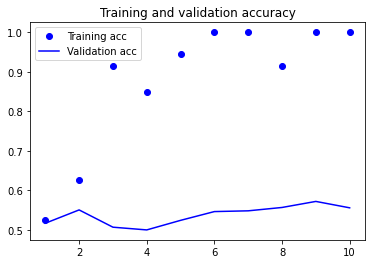

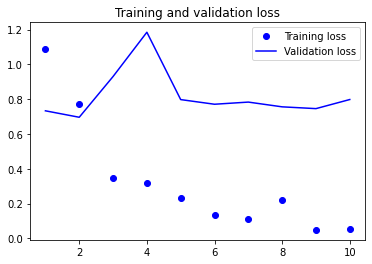

In [ ]:
# 결과 그래프 그리기
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label = "Training acc")
plt.plot(epochs, val_acc, 'b', label = "Validation acc")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()


plt.plot(epochs, loss, 'bo', label = "Training loss")
plt.plot(epochs, val_loss, 'b', label = "Validation loss")
plt.title("Training and validation loss")
plt.legend()

모델이 단시간에 과대적합이 이뤄졌음을 확인 할 수 있음  

이와 같이 빠르게 과대적합이 이뤄지면  
사전 훈련된 단어 임베딩을 사용하지 않거나  
임베딩 층을 동결하지 않고 같은 모델을 훈련 시키는 방법을 사용  


In [ ]:
# 사전 훈련된 단어 임베딩을 사용하지 않고 같은 모델 훈련하기
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length = maxlen))
model.add(Flatten())
model.add(Dense(32, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer = 'rmsprop',
              loss = 'binary_crossentropy',
              metrics = ['acc'])
history = model.fit(x_train,
                    y_train,
                    epochs = 10,
                    batch_size = 32,
                    validation_data = (x_val, y_val))

Epoch 1/10
7/7 [==============================] - 1s 136ms/step - loss: 0.6965 - acc: 0.5265 - val_loss: 0.6928 - val_acc: 0.5042
Epoch 2/10
7/7 [==============================] - 1s 100ms/step - loss: 0.5333 - acc: 0.9888 - val_loss: 0.6992 - val_acc: 0.5059
Epoch 3/10
7/7 [==============================] - 1s 108ms/step - loss: 0.3616 - acc: 0.9950 - val_loss: 0.7576 - val_acc: 0.5027
Epoch 4/10
7/7 [==============================] - 1s 107ms/step - loss: 0.2048 - acc: 0.9823 - val_loss: 0.7359 - val_acc: 0.5027
Epoch 5/10
7/7 [==============================] - 1s 105ms/step - loss: 0.1122 - acc: 1.0000 - val_loss: 0.7313 - val_acc: 0.5148
Epoch 6/10
7/7 [==============================] - 1s 104ms/step - loss: 0.0545 - acc: 1.0000 - val_loss: 0.7113 - val_acc: 0.5195
Epoch 7/10
7/7 [==============================] - 1s 100ms/step - loss: 0.0314 - acc: 1.0000 - val_loss: 0.7255 - val_acc: 0.5186
Epoch 8/10
7/7 [==============================] - 1s 107ms/step - loss: 0.0169 - acc: 1.00

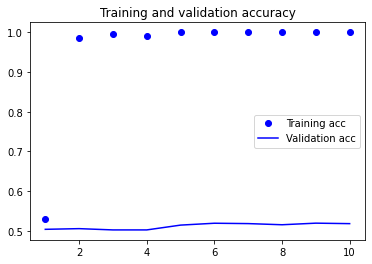

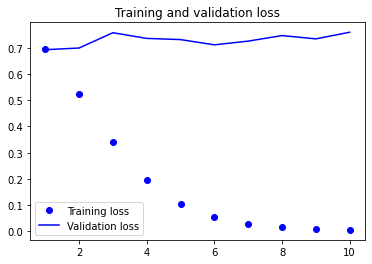

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label = "Training acc")
plt.plot(epochs, val_acc, 'b', label = "Validation acc")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()


plt.plot(epochs, loss, 'bo', label = "Training loss")
plt.plot(epochs, val_loss, 'b', label = "Validation loss")
plt.title("Training and validation loss")
plt.legend()

사전 훈련된 임베딩을 사용 여부에 따라  
그래프의 모양이 변화함  

검증 데이터의 평균적인 정확도의 측면에서는 비슷하지만,  
사전 훈련 모델을 사용했을 때 보다 안정적인 손실과 정확도를 나타냄  



In [ ]:
# 테스트 데이터 토큰화하기
test_dir = os.path.join(imdb_dir, 'test')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in sorted(os.listdir(dir_name)):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname), encoding = 'utf-8')
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen = maxlen)
y_test = np.asarray(labels)

In [ ]:
# 테스트 세트에서 모델 평가하기
model.load_weights('pre_trained_glove_model.h5')
model.evaluate(x_test, y_test)

782/782 [==============================] - 2s 2ms/step - loss: 0.8024 - acc: 0.5532


[0.8023595809936523, 0.5531600117683411]

## 6.2 순환 신경망 이해하기
완전 연결 네트워크와 컨브넷의 특징은 메모리가 없다는 것  
입력에 대한 내용을 유지하지 않고 주입 될 때마다 처리함  
시퀀스나 시계열 데이터를 다루기 위해선 전체 시퀀스를 주입해야만 함  
이를 **피드포워드 네트워크** 라 함

하지만, 사람은 이전의 내용 및 단어를 기억하며 문장을 읽음  
이를 단순하게 만든 신경망이 **순환 신경망(RNN)**  
시퀀스의 원소를 순회하며 지금까지 처리한 정보를 상태에 저장  

RNN 작동 방식
- RNN은 크기가 (timesteps, input_features)인 2D 텐서로 인코딩된 벡터의 시퀀스를 입력 받음  
- 각 타임스텝 t에서 현재 상태와 ((input_features,) 크기의) 입력을 연결하여 출력
- 위의 출력을 다음 스텝의 상태로 설정
- 첫 번째 타임 스텝은 이전 출력이 정의 되지 않아서 초기 상태인 0벡터로 상태를 초기화



In [ ]:
# 의사코드로 표현한 RNN
state_t = 0
for input_t in input_sequence:
    output_t = f(input_t, state_t)
    state_t = output_t

In [ ]:
# 좀 더 자세한 의사코드로 표현한 RNN
state_t = 0
for input_t in input_sequence:
    output_t = activation(dot(W, input_t) + dot(U, state_t) + b)
    state_t = output_t

In [ ]:
# 넘파이로 구현한 간단한 RNN
import numpy as np

timesteps = 100
input_features = 32
output_features = 64

inputs = np.random.random((timesteps, input_features))

state_t = np.zeros((output_features, ))

W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features, ))

successive_outputs = []
for input_t in inputs:
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
    successive_outputs.append(output_t)
    state_t = output_t

final_output_sequence = np.stack(successive_outputs, axis = 0)

### 케라스의 순환층
넘파이로 구현한 과정이 실제 케라스 SimpleRNN층에 해당

차이점은  
(timesteps, input_features)의 크기가 아니라  
(batch_size, timesteps, input_features) 크기의 입력을 받음

In [ ]:
# SimpleRNN을 사용해 마지막 타임스텝의 출력 얻기
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN

model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          320000    
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 32)                2080      
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


여기서 SimpleRNN의 파라미터 수는  
SimpleRNN의 입력 특성 크기는 Embedding 층의 출력 특성 크기인 32,  
W = 32 * 32, U = 32 * 32, b = 32  
파라미터 = 32 * 32 + 32 * 32 + 32

In [ ]:
# SimpleRNN을 사용해 전체 상태 시퀀스 반환
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences = True))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, None, 32)          2080      
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# 전체 타임스텝의 출력을 받는 여러개의 SimpleRNN 층
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences = True))
model.add(SimpleRNN(32, return_sequences = True))
model.add(SimpleRNN(32, return_sequences = True))
model.add(SimpleRNN(32))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_5 (SimpleRNN)     (None, 32)                2080      
Total params: 328,320
Trainable params: 328,320
Non-trainable params: 0
_________________________________________________________________


In [1]:
# IMDB 데이터 전처리하기
from keras.datasets import imdb
from keras.preprocessing import sequence

max_features = 10000
maxlen = 500
batch_size = 32

print('데이터 로딩...')
(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words = max_features)
print(len(input_train), '훈련 시퀀스')
print(len(input_test), '테스트 시퀀스')

print('시퀀스 패딩 (sample * time)')
input_train = sequence.pad_sequences(input_train, maxlen = maxlen)
input_test = sequence.pad_sequences(input_test, maxlen = maxlen)
print('input_train 크기:', input_train.shape)
print('input_test 크기:', input_test.shape)

데이터 로딩...
17465344/17464789 [==============================] - 0s 0us/step


<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 

25000 훈련 시퀀스
25000 테스트 시퀀스
시퀀스 패딩 (sample * time)
input_train 크기: (25000, 500)
input_test 크기: (25000, 500)


Embedding 층과 SimpleRNN 층을 사용하여 간단한 순환 네트워크 훈련 시키기


In [ ]:
# Embedding 층과 SimpleRNN 층을 사용한 모델 훈련하기
from keras.layers import Dense

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(SimpleRNN(32))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(optimizer = 'rmsprop',
              loss = 'binary_crossentropy',
              metrics = ['acc'])
history = model.fit(input_train,
                    y_train,
                    epochs = 10,
                    batch_size = 128,
                    validation_split = 0.2)

Epoch 1/10
157/157 [==============================] - 25s 148ms/step - loss: 0.6660 - acc: 0.5764 - val_loss: 0.4862 - val_acc: 0.7706
Epoch 2/10
157/157 [==============================] - 22s 141ms/step - loss: 0.4005 - acc: 0.8315 - val_loss: 0.3489 - val_acc: 0.8620
Epoch 3/10
157/157 [==============================] - 22s 142ms/step - loss: 0.3054 - acc: 0.8825 - val_loss: 0.3822 - val_acc: 0.8516
Epoch 4/10
157/157 [==============================] - 22s 140ms/step - loss: 0.2322 - acc: 0.9145 - val_loss: 0.3503 - val_acc: 0.8698
Epoch 5/10
157/157 [==============================] - 22s 140ms/step - loss: 0.1691 - acc: 0.9379 - val_loss: 0.4095 - val_acc: 0.8648
Epoch 6/10
157/157 [==============================] - 22s 142ms/step - loss: 0.1520 - acc: 0.9454 - val_loss: 0.4120 - val_acc: 0.8484
Epoch 7/10
157/157 [==============================] - 22s 143ms/step - loss: 0.0958 - acc: 0.9696 - val_loss: 0.3910 - val_acc: 0.8700
Epoch 8/10
157/157 [==============================] - 2

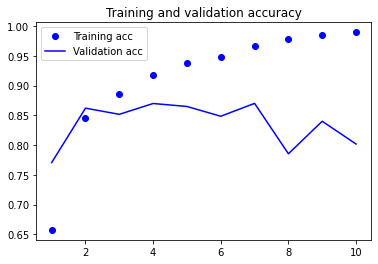

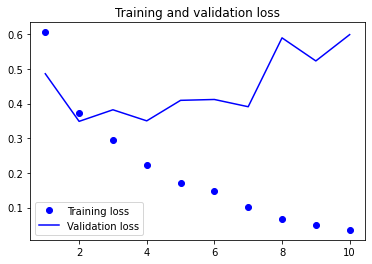

In [ ]:
# 결과 그래프 그리기
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()

3장의 모델과 비교했을 때 정확도가 조금 낮은데  
이는 전체 시퀀스가 아닌 순서대로 500개의 단어만 입력에 사용 했기 때문  


### LSTM과 GRU 층 이해하기
실전엔서 SimpleRNN 보단 LSTM과 GRU 를 많이 사용  
SimpleRNN의 경우 이론적으로 시간 t에서 이전의 모든 타임 스텝의 정보를 유지할 수 있으나,  
실제론 긴 시간에 걸친 의존성은 학습할 수 없음   
그래디언트 소실 문제 발생   
이를 해결하기 위해 만든 것이 LSTM과 GRU

LSTM  
RNN층을 기반으로 이뤄져 있으며  
시퀀스 어느 지점에서 추출된 정보가 필요한 시점의 타임스텝에 제공하는 구조를 추가함




In [ ]:
# LSTM 구조의 의사코드
output_t = activation(c_t) * activation(dot(input_t, Wo) + dot(state_t, Uo) + bo)

i_t = activation(dot(state_t, Ui) + dot(input_t, Wi) + bi)
f_t = activation(dot(state_t, Uf) + dot(input_t, Wf) + bf)
k_t = activation(dot(state_t, Uk) + dot(input_t, Wk) + bk)

c_t + 1 = i_t * k_t + c_t * f_t

여기서 문자 'o' 는 output을 의미하며  
문자 'c'는 이동을 의미합니다.

i, f, k 는 자신만의 가중치 행렬  

### 케라스를 사용한 LSTM 예제

In [2]:
# IMDB 데이터셋 불러오기
from keras.datasets import imdb
from keras.preprocessing import sequence

max_features = 10000
maxlen = 500
batch_size = 32

print('데이터 로딩...')
(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words = max_features)
print(len(input_train), '훈련 시퀀스')
print(len(input_test), '테스트 시퀀스')

print('시퀀스 패딩 (sample * time)')
input_train = sequence.pad_sequences(input_train, maxlen = maxlen)
input_test = sequence.pad_sequences(input_test, maxlen = maxlen)
print('input_train 크기:', input_train.shape)
print('input_test 크기:', input_test.shape)

데이터 로딩...


<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 

25000 훈련 시퀀스
25000 테스트 시퀀스
시퀀스 패딩 (sample * time)
input_train 크기: (25000, 500)
input_test 크기: (25000, 500)


In [5]:
# 케라스에서 LSTM 층 사용하기
from keras.models import Sequential
from keras.layers import Embedding, Dense, LSTM

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(LSTM(32))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(optimizer = 'rmsprop',
              loss = 'binary_crossentropy',
              metrics = ['acc'])

history = model.fit(input_train,
                    y_train,
                    epochs = 10,
                    batch_size = 128,
                    validation_split = 0.2)

Epoch 1/10
157/157 [==============================] - 49s 298ms/step - loss: 0.5977 - acc: 0.6771 - val_loss: 0.3615 - val_acc: 0.8476
Epoch 2/10
157/157 [==============================] - 51s 327ms/step - loss: 0.2938 - acc: 0.8860 - val_loss: 0.3079 - val_acc: 0.8768
Epoch 3/10
157/157 [==============================] - 50s 318ms/step - loss: 0.2299 - acc: 0.9163 - val_loss: 0.2967 - val_acc: 0.8816
Epoch 4/10
157/157 [==============================] - 53s 339ms/step - loss: 0.1902 - acc: 0.9307 - val_loss: 0.3640 - val_acc: 0.8494
Epoch 5/10
157/157 [==============================] - 53s 338ms/step - loss: 0.1768 - acc: 0.9360 - val_loss: 0.3080 - val_acc: 0.8696
Epoch 6/10
157/157 [==============================] - 54s 347ms/step - loss: 0.1538 - acc: 0.9472 - val_loss: 0.2966 - val_acc: 0.8846
Epoch 7/10
157/157 [==============================] - 53s 334ms/step - loss: 0.1378 - acc: 0.9509 - val_loss: 0.3129 - val_acc: 0.8822
Epoch 8/10
157/157 [==============================] - 5

Text(0.5, 1.0, 'Training and validation loss')

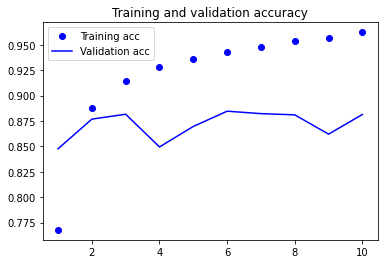

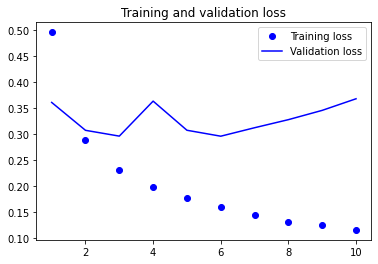

In [6]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
plt.legend()
plt.title("Training and validation accuracy")
plt.figure()

plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.legend()
plt.title("Training and validation loss")

검증 정확도가 SimpleRNN을 사용했을 때 보다 더 나은 모습을 보임  
이는 LSTM이 그래디언트 소실 문제로 부터 덜 영향을 받기 때문  

## 6.3 순환 신경망의 고급 사용법
순환 신경망의 성능과 일반화 능력을 향상시키는 방법
- 순환 드롭아웃
- 스태킹 순환 층
- 양방향 순환 층

### 기온 예측 문제
날씨 시계열 데이터셋  
**수년간에 걸쳐 (기온, 습도, 기압, 풍향 등) 14개의 관측치가 10분마다 기록된 데이터**

In [5]:
from google.colab import drive 
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [6]:
%cd /content/gdrive/MyDrive/datasets/

/content/gdrive/MyDrive/datasets


In [9]:
!mkdir jena_climate
%cd jena_climate
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2021-01-02 05:35:32--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.128.109
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.128.109|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  50.8MB/s    in 0.3s    

2021-01-02 05:35:33 (50.8 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


In [8]:
# 예나의 날씨 데이터셋 조사하기
fname = 'jena_climate_2009_2016.csv'

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [9]:
# 데이터 파싱하기
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

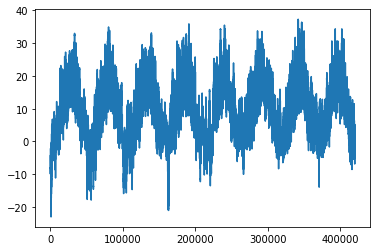

In [23]:
# 시계열 온도 그래프 그리기
import matplotlib.pyplot as plt

temp = float_data[:,1]
plt.plot(range(len(temp)), temp)

10분마다 데이터가 기록돼 이쏘 하루 총 144개의 데이터 포인트가 존재함

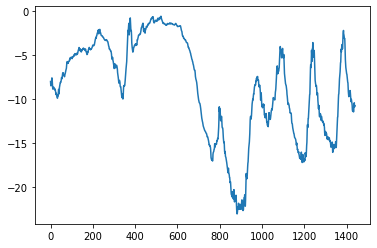

In [25]:
# 처음 10일간 온도 그래프 그리기
plt.plot(range(1440), temp[:1440])

그래프를 봤을 때 모두 영하의 날씨이고,  
영하 20도 아래까지 내려가는 것으로 보아  
가장 추운 겨울 중 10일의 데이터로 보임  


### 데이터 준비
**문제 정의**  
lookback 타임스텝만큼 이전으로 돌아가서  
매 steps 타임스텝마다 샘플링  
이 데이터를 바탕으로 delay 타임스텝 이후 온도 예측
- lookback = 1440 : 10일 전 데이터로 돌아감
- steps = 6 : 1시간마다 데이터 포인트 하나 샘플링
- delay = 144 : 24시간이 지난 데이터가 타겟  

이를 수행하기 위해선 데이터 전처리가 필요
- 신경망에 주입할 수 있는 형태로 변환하는데 데이터가 수치형이므로 추가적인 벡터화는 필요 없음. 다만, 각 데이터들의 측정 단위가 다르기 때문에 이를 비슷한 범위의 작은 값으로 변환 필요
- float_data 배열을 받아 과거의 데이터의 배치와 미래 타깃 온도 추출하는 제너레이터 만들기

각 시계열 특성에 대해 평균을 빼고 표준 편차로 나눠 전처리

In [10]:
# 데이터 정규화하기
mean = float_data[:200000].mean(axis = 0)
float_data -= mean
std = float_data[:200000].std(axis = 0)
float_data /= std

20만개의 데이터를 훈련 데이터로 사용할 것이기에    
20개의 데이터를 바탕으로 평균과 표준편차를 구해   
데이터 전체에 적용해주기  

제너레이터 함수 생성  
- data : 정규화한 부동 소수 데이터로 이루어진 원본 배열
- lookback : 입력으로 사용하기 위해 거슬러 올라갈 타임스텝
- delay : 타깃으로 사용할 미래의 타임스텝
- min_index, max_index : 추출할 타임스텝의 범위 지정위한 인덱스
- shuffle : 샘플을 섞거나, 시간 순서대로 추출할지를 결정
- batch_size : 배치의 샘플 수
- step : 데이터를 샘플링할 타임스텝 간격, 여기선 1시간 즉 6으로 설정


In [11]:
# 시계열 데이터와 타깃을 반환하는 제너레이터 함수
def generator(data, lookback, delay, min_index, max_index, shuffle = False, batch_size = 128, step = 6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size = batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                            lookback // step,
                            data.shape[-1]))
        targets = np.zeros((len(rows), ))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets                                     

In [12]:
# 훈련, 검증, 테스트 제너레이터 준비하기
lookback = 1440
step = 6
delay = 144
batch_size = 128
train_gen = generator(float_data,
                      lookback = lookback,
                      delay = delay,
                      min_index = 0,
                      max_index = 200000,
                      shuffle = True,
                      step = step,
                      batch_size = batch_size)
val_gen = generator(float_data,
                    lookback = lookback,
                    delay = delay,
                    min_index = 200001,
                    max_index = 300000,
                    step = step,
                    batch_size = batch_size)
test_gen = generator(float_data,
                     lookback = lookback,
                     delay = delay,
                     min_index = 300001,
                     max_index = None,
                     step = step,
                     batch_size = batch_size)

val_steps = (300000 - 200001 - lookback) // batch_size
test_steps = (len(float_data) - 300001 - lookback) // batch_size

### 상식 수준의 기준점
블랙 박스 같은 딥러닝 모델을 사용하여 온도 예측 문제를 풀기 전에 간단한 상식 수준의 해법을 시도해 보겠음   
- 이는 정상 여부 확인을 위한 용도 이며, 머신 러닝 모델이 뛰어넘어야 할 기준 점

이런 상식 수준의 해법은 알려진 해결책이 없는 새로운 문제를 다룰 때 유용  

일반적으로 온도 시계열 데이터는 연속성이 있으며 일자별로 주기성을 가진다고 가정  
상식 수준의 해결책은 지금으로부터 24시간 후 온도는 지금과 동일하다고 예측하는 것  

이를 평균 절대값 오차로 평가  


In [ ]:
np.mean(np.abs(preds - targets))

In [35]:
# 상식적인 기준 모델의 MAE 계산하기
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(format(np.mean(batch_maes), '1.5f'))

evaluate_naive_method()

0.28974


출력된 MAE는 약 0.29로
이 온도 데이터는 평균이 0이고 표준 편차가 1이므로 결과값이 바로 와닿지 않음

MAE에 표준편차를 곱하면 실제 값으로 변환 가능

In [37]:
# MAE를 섭씨 단위로 변환하기
celsius_mae = 0.28974 * std[1]
celsius_mae

2.5649230840779667

### 기본적인 머신 러닝 방법

복잡한 모델을 시도하기 전에 간단한 모델을 먼저 만드는 것이 좋음  
이를 바탕으로 복잡한 방법을 도입하는 근거가 마련되고 실제적인 이득도 얻을 수 있음  

In [38]:
# 완전 연결 모델을 훈련하고 평가하기
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape = (lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation = 'relu'))
model.add(layers.Dense(1))
model.compile(optimizer = RMSprop(),
              loss = 'mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
500/500 [==============================] - 13s 25ms/step - loss: 1.9693 - val_loss: 0.7200
Epoch 2/20
500/500 [==============================] - 13s 25ms/step - loss: 0.5497 - val_loss: 0.3249
Epoch 3/20
500/500 [==============================] - 13s 26ms/step - loss: 0.3036 - val_loss: 0.3261
Epoch 4/20
500/500 [==============================] - 13s 26ms/step - loss: 0.2753 - val_loss: 0.3316
Epoch 5/20
500/500 [==============================] - 13s 26ms/step - loss: 0.2591 - val_loss: 0.3495
Epoch 6/20
500/500 [==============================] - 13s 26ms/step - loss: 0.2490 - val_loss: 0.3220
Epoch 7/20
500/500 [==============================] - 13s 25ms/step - loss: 0.2421 - val_loss: 0.3579
Epoch 8/20
500/500 [==============================] - 13s 25ms/step - loss: 0.2353 - val_loss: 0.3585
Epoch 9/20
500/500 [==============================] - 13s 26ms/step - loss: 0.2324 - val_loss: 0.3155
Epoch 10/20
500/500 [==============================] - 13s 27ms/step - loss: 0.228

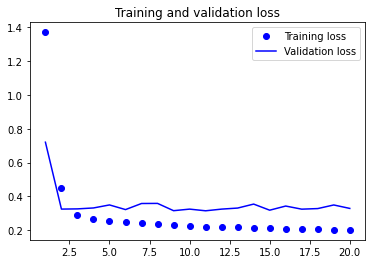

In [39]:
# 결과 그래프 그리기
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()

일부 검증 손실은 학습을 사용하지 않은 기준점에 가깝지만 안정적이지 못함  
우리가 적용한 상식에는 머신 러닝 모델이 찾지 못한 핵심 정보가 많음  



### 첫 번째 순환 신경망
첫 번째 완전 연결 네트워크는 잘 작동하지 않음  
시계열 데이터를 펼쳐서 데이터의 시간 개념을 잃은 것으로 보임  
이번엔 펼치지 않고 인과 관계와 순서가 의미 있는 시퀀스 데이터를 사용 해 적용  

이번에 사용할 층은 GRU로  
LSTM과 같은 원리로 작용하지만 계산 비용이 덜 듦

In [12]:
# GRU를 사용한 모델을 훈련하고 평가하기
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape = (None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer = RMSprop(),
              loss = 'mae')

history = model.fit_generator(train_gen,
                              steps_per_epoch = 500,
                              epochs = 20,
                              validation_data = val_gen,
                              validation_steps = val_steps)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
500/500 [==============================] - 24s 33ms/step - loss: 0.3371 - val_loss: 0.2702
Epoch 2/20
500/500 [==============================] - 16s 33ms/step - loss: 0.2850 - val_loss: 0.2685
Epoch 3/20
500/500 [==============================] - 16s 32ms/step - loss: 0.2796 - val_loss: 0.2630
Epoch 4/20
500/500 [==============================] - 16s 31ms/step - loss: 0.2722 - val_loss: 0.2620
Epoch 5/20
500/500 [==============================] - 16s 31ms/step - loss: 0.2707 - val_loss: 0.2620
Epoch 6/20
500/500 [==============================] - 16s 32ms/step - loss: 0.2642 - val_loss: 0.2584
Epoch 7/20
500/500 [==============================] - 16s 32ms/step - loss: 0.2598 - val_loss: 0.2641
Epoch 8/20
500/500 [==============================] - 16s 31ms/step - loss: 0.2554 - val_loss: 0.2652
Epoch 9/20
500/500 [==============================] - 16s 32ms/step - loss: 0.2521 - val_loss: 0.2709
Epoch 10/20
500/500 [==============================] - 16s 32ms/step - loss: 0.246

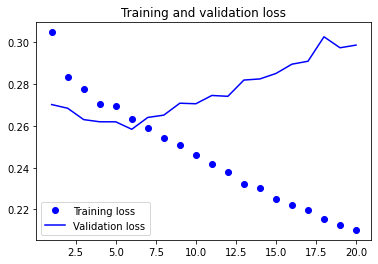

In [13]:
# 결과 그래프 그리기
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()

일정 epoch를 지나면 검증 loss가 훈련 loss보다 증가 하여 차이가 벌어짐  


### 과대적합을 감소하기 위해 순환 드롭아웃 사용하기
**드롭아웃 **  
훈련 데이터를 층에 주입할 때 데이터에 있는 우연한 상관관계를 깨기 위해  
입력 층의 유닛을 랜덤하게 끄는 기법

하지만, 순환 층 이전에 드롭아웃을 적용하면 규제에 도움이 되지 않고 학습에 더 방해 됨  
이를 보완하기 위해 동일한 드롭아웃을 모든 타임스텝에 적용  

In [16]:
# 드롭아웃 규제된 GRU를 사용한 모델을 훈련하고 평가하기
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout = 0.2,
                     recurrent_dropout = 0.2,
                     input_shape = (None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer = RMSprop(),
              loss = 'mae')

history = model.fit_generator(train_gen,
                              steps_per_epoch = 500,
                              epochs = 40,
                              validation_data = val_gen,
                              validation_steps = val_steps)

Epoch 1/40


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


500/500 [==============================] - 442s 880ms/step - loss: 0.3830 - val_loss: 0.2820
Epoch 2/40
500/500 [==============================] - 437s 875ms/step - loss: 0.3094 - val_loss: 0.2823
Epoch 3/40
500/500 [==============================] - 412s 824ms/step - loss: 0.3004 - val_loss: 0.2748
Epoch 4/40
500/500 [==============================] - 411s 822ms/step - loss: 0.2949 - val_loss: 0.2725
Epoch 5/40
500/500 [==============================] - 410s 820ms/step - loss: 0.2911 - val_loss: 0.2779
Epoch 6/40
500/500 [==============================] - 410s 821ms/step - loss: 0.2873 - val_loss: 0.2887
Epoch 7/40
500/500 [==============================] - 412s 825ms/step - loss: 0.2853 - val_loss: 0.2743
Epoch 8/40
500/500 [==============================] - 414s 828ms/step - loss: 0.2841 - val_loss: 0.2693
Epoch 9/40
500/500 [==============================] - 411s 822ms/step - loss: 0.2793 - val_loss: 0.2828
Epoch 10/40
500/500 [==============================] - 415s 831ms/step - lo

dropout : 층의 입력에 대한 드롭아웃 비율을 정하는 부동 소수 값  
recurrent_dropout : 순환 상태의 드롭아웃 비율

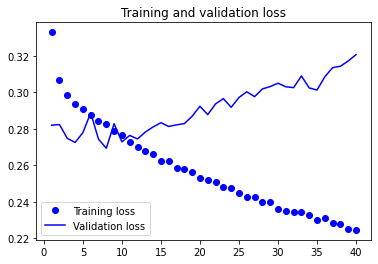

In [17]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()

이전 모델에 비해 과대적합 일어나는 속도가 줄긴 했지만,  
여전히 존재 함  
이땐 드롭아웃 비율을 높여 진행해보면 좋을 듯  

In [13]:
# 드롭아웃 규제된 GRU를 사용한 모델을 훈련하고 평가하기
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout = 0.2,
                     recurrent_dropout = 0.5,
                     input_shape = (None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer = RMSprop(),
              loss = 'mae')

history = model.fit_generator(train_gen,
                              steps_per_epoch = 500,
                              epochs = 5,
                              validation_data = val_gen,
                              validation_steps = val_steps)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
500/500 [==============================] - 412s 820ms/step - loss: 0.3685 - val_loss: 0.2772
Epoch 2/5
500/500 [==============================] - 409s 818ms/step - loss: 0.3128 - val_loss: 0.2787
Epoch 3/5
500/500 [==============================] - 409s 819ms/step - loss: 0.3051 - val_loss: 0.2764
Epoch 4/5
500/500 [==============================] - 407s 815ms/step - loss: 0.3034 - val_loss: 0.2758
Epoch 5/5
500/500 [==============================] - 411s 822ms/step - loss: 0.2952 - val_loss: 0.2788


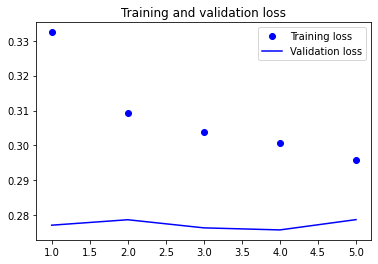

In [14]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()

시간이 많이 걸려 5번 밖에 돌리지 못했지만,  
아직 까지는 과대적합이 일어나지 않았음  

충분한 epoch를 이용하고도 과대적합이 일어나지 않았을 경우엔  
네트워크의 용량을 늘리는 것이 좋음
- 유닛의 수를 늘림
- 층을 늘림

### 스태킹 순환 층
과대적합은 없지만 성능상 병목이 있는 것 같으므로 네트워크 용량을 늘려야 함  
이땐, 과대적합이 일어날 때 까지 네트워크의 용량을 늘리는 것이 좋음  

In [ ]:
# 드롭아웃으로 규제하고 스태킹한 GRU 모델을 훈련하고 평가하기
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout = 0.1,
                     recurrent_dropout = 0.5,
                     return_sequences = True,
                     input_shape = (None, float_data.shape[-1])))
model.add(layers.GRU(64, activation = 'relu',
                     dropout = 0.1,
                     recurrent_dropout = 0.5))
model.add(layers.Dense(1))
model.compile(optimizer = RMSprop(),
              loss = 'mae')

history = model.fit_generator(train_gen, 
                              steps_per_epoch = 500,
                              epochs = 40,
                              validation_data = val_gen,
                              validation_steps = val_steps)

층을 추가하여 성능을 조금 향상시켰지만 크지는 않음  

여기서 두가지 결론을 낼 수 있음
- 아직 충분히 과대적합을 만들지 못해 검증 손실을 향상하기 위해서 층의 크기를 늘리기. 하지만, 그만큼 많은 비용을 필요로하기에 시간이 많이 걸림
- 층을 추가한 만큼 도움이 되지 않았으므로, 네트워크의 용량을 늘리는 것이 도움이 되지 않을 수 있음

### 양뱡향 RNN 사용하기
**시퀀스를 양쪽 방향으로 처리하는 RNN 모델**  

양방향으로 RNN을 처리하여 단방향 RNN이 놓치기 쉬운 패턴을 감지할 수 있음

In [ ]:
# 거꾸로 된 시퀀스를 사용한 LSTM을 훈련하고 평가하기
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras import layers
from keras.models import Sequential

max_features = 10000
maxlen = 500

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words = max_features)

x_train = [x[::-1] for x in x_train]
x_test = [x[::-1] for x in x_test]

x_train = sequence.pad_sequences(x_train, maxlen = maxlen)
x_test = sequence.pad_sequences(x_test, maxlen = maxlen)

model = Sequential()
model.add(layers.Embedding(max_features, 128))
model.add(layers.LSTM(32))
model.add(layers.Dense(1, activation = 'sigmoid'))

model.compile(optimizer = 'rmsprop',
              loss = 'binary_crossentropy',
              metrics = ['acc'])

history = model.fit(x_train,
                    y_train,
                    epochs = 10,
                    batch_size = 128,
                    validation_split = 0.2)

위 모델은 시간 순서대로 처리했을 때랑 거의 동일하게 작동 됨  
위 모델은 시간 순서대로 처리했을 때랑 거의 동일하게 작동 됨  
이는 언어를 이해하는 데 단어의 순서가 중요하지만 결정적이지 않다는 가정을 뒷받침  

In [ ]:
# 양방향 LSTM을 훈련하고 평가하기
model = Sequential()
model.add(layers.Embedding(max_features, 32))
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Dense(1, activation = 'sigmoid'))

model.compile(optimizer = 'rmsprop',
              loss = 'binary_crossentropy',
              metrics = ['acc'])
history = model.fit(x_train,
                    y_train,
                    batch_size = 128,
                    validation_split = 0.2)